In [1]:
#/usr/bin/python3.8
# Use jupyter notebook with python 3+ 
"""
Auth : Al Sabawi
Date: Mar 14, 2020
"""
# Need the following libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Source

#### Johns Hupkins Whiting School of Engineering COVID-19 Data Repository at https://github.com/CSSEGISandData

## Download the data to your computer daily

In [2]:
## Download the latest data file from:
## https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
## File name "time_series_19-covid-Confirmed.csv"  for all confirmed cases in the world by region
## *** DOWNLOAD to local directory ***
confirmed_filename = './time_series_19-covid-Confirmed.csv'
recovered_filename = './time_series_19-covid-Recovered.csv'
deaths_filename = './time_series_19-covid-Deaths.csv'

df_confirmed = pd.read_csv(confirmed_filename)
df_recovered = pd.read_csv(recovered_filename)
df_deaths = pd.read_csv(deaths_filename)

## Separate the dates to use as an index later
dates = df_confirmed.columns[4:]
## Filter for a specific region data only 
region = 'US'
usa = df_confirmed[df_confirmed['Country/Region'].values == region].copy(deep=True)
usa_recovered = df_recovered[df_recovered['Country/Region'].values == region].copy(deep=True)
usa_deaths = df_deaths[df_deaths['Country/Region'].values == region].copy(deep=True)

usad = usa[dates].copy(deep=True)
last_date = usa[dates].columns[-1]

## Put the US data into a DataFrame Series and give it a name
colname = 'Confirmed '+region+' COVID-19 Cases'
colname_recovered = 'Recovered in '+region+' from COVID-19 Cases'
colname_deaths = 'Deaths in '+region+' from COVID-19 Cases'

us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])
us_df_cumulative['dates'] = dates
us_df_recovered_cum = pd.DataFrame(usa_recovered[dates].sum(), columns=[colname_recovered])
us_df_deaths_cum = pd.DataFrame(usa_deaths[dates].sum(), columns=[colname_deaths])

# Check: These 2 following prints should give the same number on same Last Dates data is collected
#print(last_date, usad[last_date].sum())
#print(us_df_cumulative[-1:])

## Plot the confirmed COVID-19 Cases

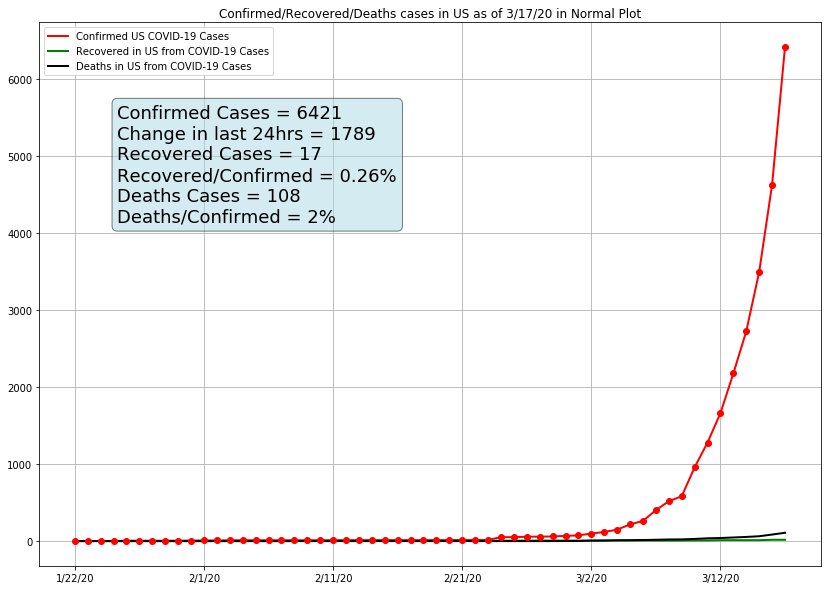

In [3]:
## Plot the raw data (not logarithmic)
fig, ax = plt.subplots(figsize=(14,10))
#us_df = pd.DataFrame(usa[dates].sum(), columns=[colname])

us_df_cumulative.plot(ax=ax,c='red', lw=2,title='Confirmed/Recovered/Deaths cases in '+region+' as of '+str(us_df_cumulative.index[-1])+' in Normal Plot')
us_df_recovered_cum.plot(ax=ax,c='green', lw=2)
us_df_deaths_cum.plot(ax=ax,c='black', lw=2)

ax.plot(us_df_cumulative[colname],'o',c='red',lw=8)

last_conf = us_df_cumulative[colname][-1:][0]
last_recov = us_df_recovered_cum[colname_recovered][-1:][0]
last_death = us_df_deaths_cum[colname_deaths][-1:][0]
last_conf_change = us_df_cumulative[colname][-1:][0] - us_df_cumulative[colname][-2:][0]

textstr = '\n'.join((
        r'Confirmed Cases = %.0f' % (last_conf, ),
        r'Change in last 24hrs = %.0f' % (last_conf_change,),
        r'Recovered Cases = %.0f' % (last_recov, ),
        r'Recovered/Confirmed = %.2f%%' % (last_recov*100/last_conf, ),
        r'Deaths Cases = %.0f' % (last_death, ),
        r'Deaths/Confirmed = %.0f%%' % (last_death*100/last_conf, )))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
ax.text(0.1, 0.85, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

ax.grid(True,which="both")

## Calculate R-naught 

### Form more info on R-naught, check https://en.wikipedia.org/wiki/Basic_reproduction_number

In [4]:
## ASSUMPTION:
##    1) In early stages of contagion, there is NO limiting factor for the spreading of virus
##    2) Uninficted Population is very close to total population
##    3) Assume Free movement (No lockdowns) of individuals in and out of areas affected by virus
##

## Find Last day's total cases
TotalCasesToDate = us_df_cumulative[colname][-1:][0]

## Create a new Series that calculates the difference from day to day

ChangeFromDay2Next = us_df_cumulative[colname].diff(1)
us_df_cumulative[colname] = us_df_cumulative[us_df_cumulative[colname] > 0].copy(deep=True)
us_df_cumulative[colname] = us_df_cumulative[colname].dropna()
ChangeFromDay2NextPercent = us_df_cumulative[colname].pct_change(1)

## Find the Average change from day to day
AverageChangeFromDay2Next = ChangeFromDay2Next.mean()

## Create a series of R0 by calculating the ratio of one day to the day before
r0 = [] # Will record the ratio day to day, start from day 1 to last day
for day in range(1,len(ChangeFromDay2Next)):
    if(ChangeFromDay2Next[day-1:][0] == 0): # Avoid dividing by zero
        r0.append(0)
    else:
        r0.append(ChangeFromDay2Next[day:][0]/ChangeFromDay2Next[day-1:][0] )  

## Look back 20 days only. This is the most relevant data        
GoBackDays = 20
dict0 = {'Date' : us_df_cumulative.index[-GoBackDays:].values, 'R-Naught' : r0[-GoBackDays:]}
R_Naught= pd.DataFrame(dict0)    
R_Naught = R_Naught.set_index('Date')

#print('ChangeFromDay2Next' , ChangeFromDay2Next[-1:][0])
DailyDelta = ChangeFromDay2Next[-1:][0]

#print(us_df_cumulative['Actual USA COVID-19 Cases'][-2:][0])
DailyDeltaPercent = 100 * DailyDelta /us_df_cumulative[colname][-2:][0]

## Descriptive Summary

In [5]:
print('-- This is for region :', region)
print("-- Total cases as of " +str(us_df_cumulative.index[-1:][0]) + "(End of day) is "+str(TotalCasesToDate),
      'cases' )
print("-- Average case count change from one day to next = ", np.round(AverageChangeFromDay2Next,2),' cases')

print("-- Change in "+region+" confirmed COVID-19 cases FROM",
      str(us_df_cumulative.index[-2:][0]), "TO", 
      str(us_df_cumulative.index[-1:][0])+ "(End of day) is " + str(int(DailyDelta)),'cases',
      "OR " +str(np.round(DailyDeltaPercent,2)) + '% from previous case total. ', '\n-- This is', 
      np.round((DailyDelta/AverageChangeFromDay2Next),2) ,
      'Times the Average count in daily changes. \n-- The current Average PERCENT(%) change from day to day is' , 
      str(np.round(100*ChangeFromDay2NextPercent.mean(),2) )+'%'+' from previous case total.', 
      "This means it's Above or Below (if negative) the average daily % change by "+ str(np.round(100*ChangeFromDay2NextPercent.mean(),2) )+'%')
print("-- R-naught value as of end-of-day",str(us_df_cumulative.index[-1:][0]), 'IS', 
      np.round(R_Naught['R-Naught'][-1:][0],4) )
print('-- The average R-naught from the past',GoBackDays,'days is', np.round( R_Naught['R-Naught'].mean(),4))

-- This is for region : US
-- Total cases as of 3/17/20(End of day) is 6421.0 cases
-- Average case count change from one day to next =  116.73  cases
-- Change in US confirmed COVID-19 cases FROM 3/16/20 TO 3/17/20(End of day) is 1789 cases OR 38.62% from previous case total.  
-- This is 15.33 Times the Average count in daily changes. 
-- The current Average PERCENT(%) change from day to day is 21.41% from previous case total. This means it's Above or Below (if negative) the average daily % change by 21.41%
-- R-naught value as of end-of-day 3/17/20 IS 1.579
-- The average R-naught from the past 20 days is 1.7675


## Plot R-naught as a Time Series

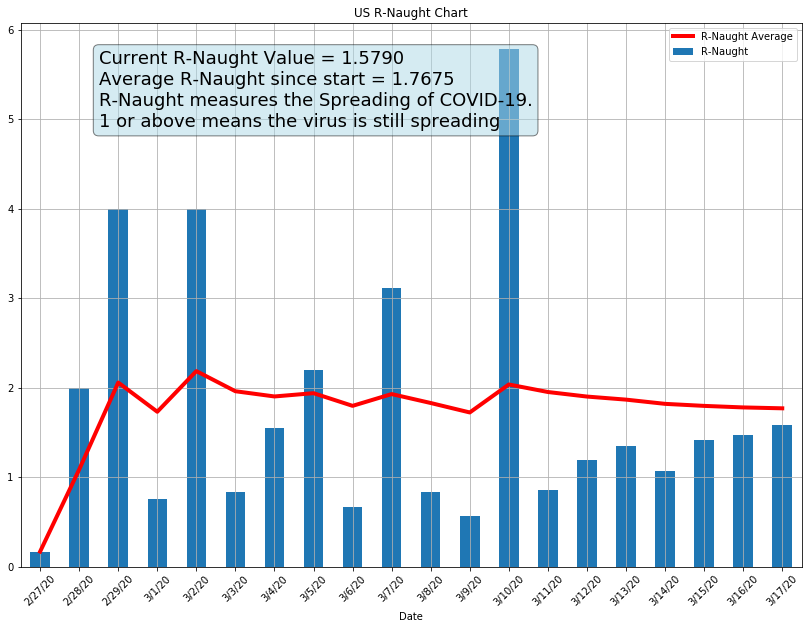

In [6]:
fig, ax = plt.subplots(figsize=(14,10))
ax.grid(True)
R_Naught['R-Naught'].plot(ax=ax,kind='bar',title=region+' R-Naught Chart')
R_Naught['R-Naught Average'] = R_Naught.expanding().mean()
R_Naught['R-Naught Average'].plot(ax=ax,c='r',grid=True,lw=4)
ax.legend()

textstr = '\n'.join((
        r'Current R-Naught Value = %.4f' % (R_Naught['R-Naught'][-1:][0], ),
        r'Average R-Naught since start = %.4f' % (R_Naught['R-Naught Average'][-1:][0],),
        r'R-Naught measures the Spreading of COVID-19.',
        r'1 or above means the virus is still spreading'))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

_ = plt.xticks(rotation=45)


### It's plausible to assume that US officials hit the panic button at the end of 3/10/2020 when R-naught spiked to near 6. R-naught should not be allowed to exceed 1.0 for the spread to die down